In [1]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="notebook")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [2]:
run_dir = f"{results_dir}run_ring_k1_1_k2s_ic_random_tend_500.0_nreps_1000_di/"
file_name = f"{run_dir}thetas_arr_ring_k1_1_k2s_ic_random_tend_500.0_nreps_1000_di.npy"

data = np.load(file_name) # end states

file_name = f"{run_dir}df_long_ring_k1_1_k2s_ic_random_tend_500.0_nreps_1000_di.csv"

df = pd.read_csv(file_name, index_col=0)



In [3]:
df[df.state == "2-cluster"]

,k2,state,proba
216,0.00,2-cluster,NaN
217,0.25,2-cluster,NaN
218,0.50,2-cluster,NaN
219,0.75,2-cluster,NaN
220,1.00,2-cluster,NaN
221,1.25,2-cluster,NaN
222,1.50,2-cluster,NaN
223,1.75,2-cluster,NaN
224,2.00,2-cluster,0.001
225,2.25,2-cluster,0.002


In [4]:
data[-2].shape

(1000, 100)

In [5]:
n_reps = 1000
i = -2

states = [identify_state(thetas[:, None], atol=0.05) for thetas in data[i]]
states_unique, counts = np.unique(states, return_counts=True)
probs = counts / n_reps

In [6]:
states_unique

array(['-1-twisted', '-2-twisted', '-3-twisted', '-4-twisted',
       '-5-twisted', '0-twisted', '2-cluster', '2-twisted', '3-twisted',
       '4-twisted', '5-twisted', '6-twisted', 'other'], dtype='<U10')

In [7]:
counts

array([  6,   3,  12,   3,   5,   4,   3,   1,   8,   6,   3,   1, 945])

In [8]:
list(states_unique).index("2-cluster")

6

In [9]:
np.where(np.array(states) == '2-cluster')

(array([501, 528, 530]),)

<Axes: >

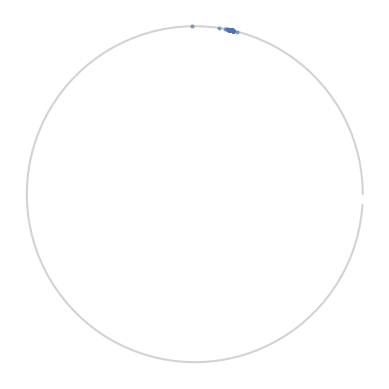

In [10]:
j = 530
plot_phases(data[i, j, :, None], it=-1)

In [40]:
identify_state(data[i, j, :, None], atol=0.05)

'2-cluster'

<Axes: >

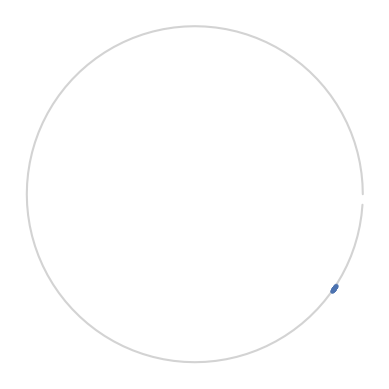

In [159]:
N = 100
#psi = generate_k_clusters(N, k=2, ps=[0.3, 0.7], noise=0.05)
psi = generate_state(N, kind="sync")

plot_phases(psi[:, None], it=-1)

In [160]:
idenfity_k_clusters(psi[:, None], k=2, t=-1, atol=0.01)

0 1


TypeError: unsupported operand type(s) for -: 'list' and 'int'

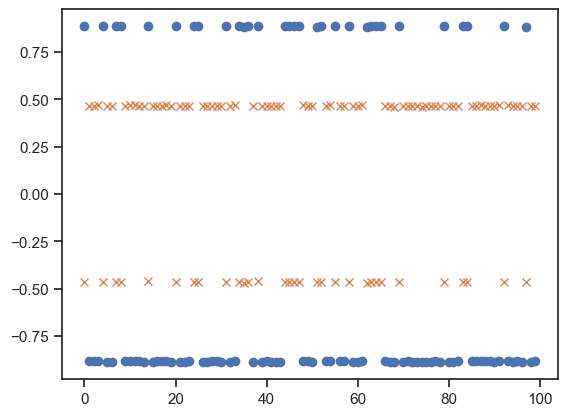

In [102]:
plt.plot(np.sin(psi), "o")
plt.plot(np.cos(psi), "x")

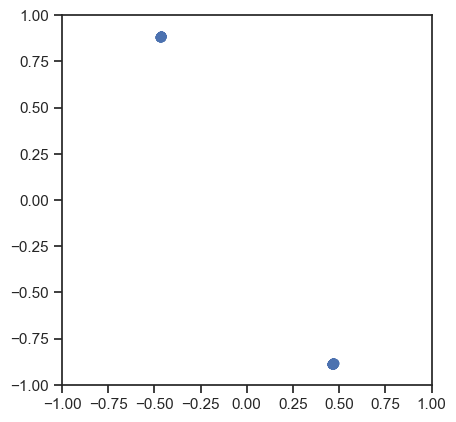

In [103]:
plt.plot(np.cos(psi), np.sin(psi), "o")

plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.gca().set_aspect("equal")

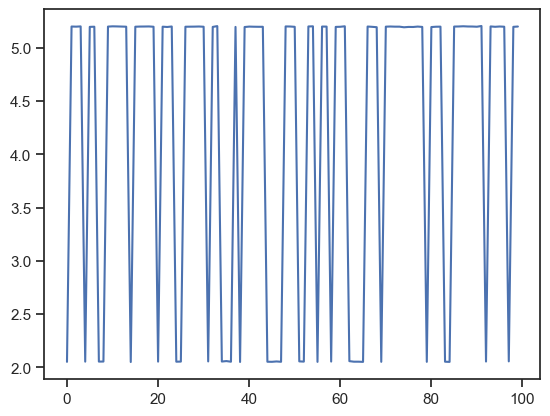

In [104]:
plt.plot(psi)

In [106]:
n_clust = 2
dist = 2*np.pi / n_clust


psi = psi % (2*np.pi)
psi = np.sort(psi)

diff = np.diff(psi)
idcs = np.where(diff > dist / 2)[0]

clust_1 = psi[:idcs[0]+1]
clust_2 = psi[idcs[0]+1:idcs[1]+1]
clust_3 = psi[idcs[1]+1:]

print(np.mean(np.diff(clust_1)))
print(np.mean(np.diff(clust_2)))
print(np.mean(np.diff(clust_3)))

print(np.mean(clust_1) - np.mean(clust_2))
print(np.mean(clust_1) - np.mean(clust_3))

print(np.mean(clust_2) - np.mean(clust_3))



IndexError: index 1 is out of bounds for axis 0 with size 1

In [114]:
def idenfity_k_clusters(thetas, k, t, atol=1e-1):
    
    n_clust = k
    dist = 2 * np.pi / n_clust
    N = len(thetas)

    psi = thetas[:, t] % (2 * np.pi)
    psi = np.sort(psi)

    diff = np.diff(psi)
    idcs = np.where(diff > dist / 2)[0]

    clusters = []
    n_changes = len(idcs)
    for i in range(n_changes + 1):
        start = idcs[i - 1] + 1 if i > 0 else None
        end = idcs[i] + 1 if i < n_changes else None
        clusters.append(psi[start:end])

    for i in range(n_changes + 1):
        if np.mean(np.diff(clusters[i])) > atol: # cluster is not compact
            print(f"cluster {i} not compact: {np.mean(np.diff(clusters[i]))}")
            return False

    for i in range(n_changes):
        dist_ij = abs(np.mean(clusters[i]) - np.mean(clusters[i+1]))
        if abs(dist_ij - dist) > atol:
            print(f"cluster {i} and {i+1} wrong distance by: {abs(dist_ij - dist)}")
            return False # clusters have wrong distance between them
    
    print(n_changes, len(clusters))
    if n_clust == len(clusters):
        sizes = [len(cluster) / N for cluster in clusters]
    elif n_clust == clusters - 1:
        sizes = [len(cluster) / N for cluster in clusters[:-1]]
        sizes[0] += len(clusters[-1]) # 0th and last clusters are the same
    else: 
        raise ValueError("n_changes must be equal to or one unit above n_clust")
    
    return True, sizes

In [92]:
np.mean(clusters[0])

0.2379991410381057

In [94]:
np.mean(clusters[-1])

6.174050046924062

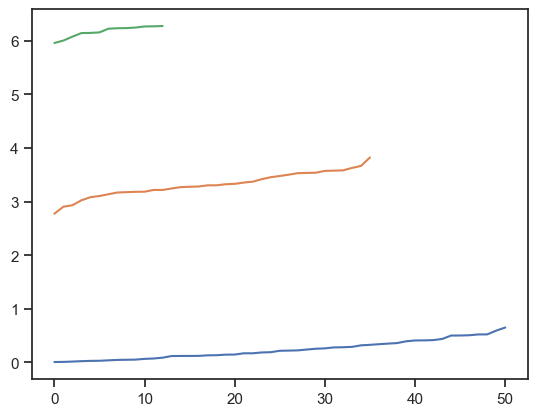

In [93]:
plt.plot(clusters[0])
plt.plot(clusters[1])
plt.plot(clusters[2])


In [58]:
len(psi)

100

In [59]:
len(clust_1) + len(clust_2)+ len(clust_3)

100

In [34]:
n_clust = 2
dist = 2*np.pi / n_clust

idcs = np.where(diff > dist / 2)

In [37]:
clust_1 = diff[:idcs[0][0]]
clust_2 = diff[:idcs[0][1]]

In [38]:
np.mean(clust_1)

0.01717383636837027

In [39]:
np.mean(clust_2)

0.04106689446248958

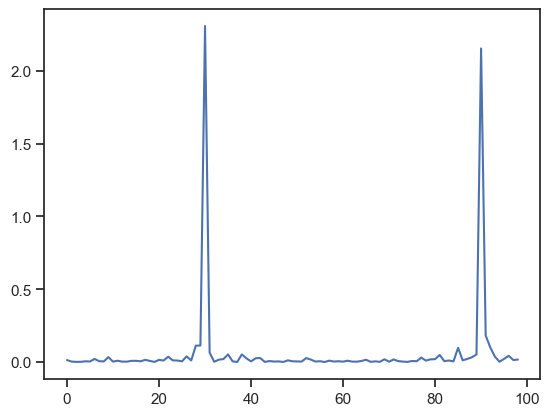

In [28]:


diff = np.diff(np.sort(psi% (2*np.pi)))

plt.plot(diff)

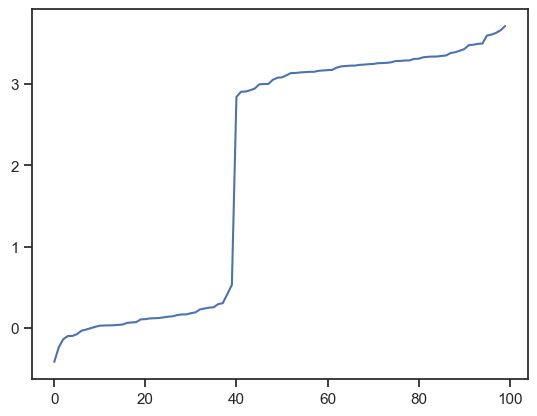

In [30]:
plt.plot(np.sort(psi) )